# RMSNorm

一种归一化方法

给定输入向量x（x的shape为[batch_size, seq_length, embedding_dim]），RMSNorm 的计算方式为：

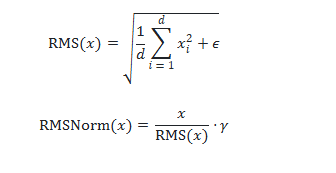

其中：

d是token特征维度数
ϵ是防止除以零的小常数
γ是可训练的缩放参数

In [1]:
import torch
import torch.nn as nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim)) # 可学习的特征缩放参数 γ
    def _norm(self, x):
        # 均方根归一化
        # torch.rsqrt就是比sqrt多一个倒数
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x):
        return self.weight * self._norm(x.float()).type_as(x)

# Example usage
x = torch.tensor([[[1.0, 2.0, 3.0, 4.0],
                   [5.0, 6.0, 7.0, 8.0]]])
norm = RMSNorm(dim=4)
output = norm(x)
print(output.shape)

torch.Size([1, 2, 4])


# RMSNorm和LayerNorm的异同

 $$ \text{LayerNorm}(\mathbf{x}) = \gamma \left( \frac{\mathbf{x} - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) + \beta $$

 RMSNorm相比LayerNorm不同点就在于没有减均值，如果均值为0，那LayerNorm就变成了RMSNorm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim)) # γ
        self.bias = nn.Parameter(torch.zeros(dim)) # β
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # 计算每个token的均值
        var = x.var(dim=-1, unbiased=False, keepdim=True) # 方差 unbiased代表是无偏方差还是有偏方差
        x_norm = (x - mean) / torch.sqrt(var +self.eps) # 标准化
        return self.weight * x_norm + self.bias

# Example usage
x = torch.tensor([[[1.0, 2.0, 3.0, 4.0],
                   [5.0, 6.0, 7.0, 8.0]]])
norm = LayerNorm(dim=4)
output = norm(x)
print(output.shape)

torch.Size([1, 2, 4])


: 

# 为什么用RMSNorm而不是LayerNorm

RMSNorm的计算比LayerNorm简单，不涉及均值，少了一个可学习的参数
在处理大型模型的时候，输入特征的纬度可能很大，RMSNorm去除了均值的计算，可以节省计算资源，效率更高